<a href="https://colab.research.google.com/github/dk-wei/tensorflow-dojo/blob/main/tf_data_api_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

这个notebook主要讲解`tf.data`这个API。优化过了的data API能够有效加快数据处理，可以直接导入TF的pipeline。对于csv data以及无法放入内存而只能放在硬盘的大数据有更好的优化效果。

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.5.0
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.5
pandas 1.1.5
sklearn 0.22.2.post1
tensorflow 2.5.0
tensorflow.keras 2.5.0


# `tf.data.Dataset.from_tensor_slices()`

可以吸收各种各样不同的数据类型(list, dict, etc)，变成tf的专属dataset

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(np.arange(10))
print(dataset)

<TensorSliceDataset shapes: (), types: tf.int64>


要循环打印数据才能看到数据是怎样的

In [ ]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [ ]:
# 1. repeat epoch
# 2. get batch

dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


In [ ]:
# interleave:
# case: 文件dataset -> 具体数据集

dataset2 = dataset.interleave(
    lambda v: tf.data.Dataset.from_tensor_slices(v), # map_fn
    cycle_length = 5, # cycle_length
    block_length = 5, # block_length
)
for item in dataset2:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype

In [ ]:
x = np.array([[1,2], [3,4], [5,6]])
y = np.array(['cat', 'dog', 'fox'])
dataset3 = tf.data.Dataset.from_tensor_slices((x, y))
for item_x, item_y in dataset3:
    print(item_x.numpy(), item_y.numpy())

[1 2] b'cat'
[3 4] b'dog'
[5 6] b'fox'


In [ ]:
dataset4 = tf.data.Dataset.from_tensor_slices({
    'feature': x,
    'label': y
})
for item in dataset4:
    print(item['feature'].numpy(), item['label'].numpy())

[1 2] b'cat'
[3 4] b'dog'
[5 6] b'fox'


In [ ]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [ ]:

from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

# `save_to_csv`

In [ ]:
output_dir = 'generate_csv'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
def save_to_csv(output_dir, data, name_prefix, 
                header=None, n_parts=10):
    path_format = os.path.join(output_dir, '{}_{:02d}.csv')
    filenames = []
    
    for file_idx, row_indices in enumerate(
        np.array_split(np.arange(len(data)), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filenames.append(part_csv)
        with open(part_csv, 'wt', encoding='utf-8') as f:
            if header is not None:
                f.write(header + '\n')
            for row_index in row_indices:
                f.write(','.join(
                [repr(col) for col in data[row_index]]))
                f.write('\n')
    
    return filenames

train_data = np.c_[x_train_scaled, y_train]
valid_data = np.c_[x_valid_scaled, y_valid]
test_data = np.c_[x_test_scaled, y_test]
header_cols = housing.feature_names + ['MidianHouseValue']
header_str = ','.join(header_cols)

train_filenames = save_to_csv(output_dir, train_data, 'train', header_str, n_parts=20)
valid_filenames = save_to_csv(output_dir, valid_data, 'valid', header_str, n_parts=10)
test_filenames = save_to_csv(output_dir, valid_data, 'test', header_str, n_parts=10)

In [ ]:
import pprint
print('train filenames:')
pprint.pprint(train_filenames)
print('valid filenames:')
pprint.pprint(valid_filenames)
print('test filenames:')
pprint.pprint(test_filenames)

train filenames:
['generate_csv/train_00.csv',
 'generate_csv/train_01.csv',
 'generate_csv/train_02.csv',
 'generate_csv/train_03.csv',
 'generate_csv/train_04.csv',
 'generate_csv/train_05.csv',
 'generate_csv/train_06.csv',
 'generate_csv/train_07.csv',
 'generate_csv/train_08.csv',
 'generate_csv/train_09.csv',
 'generate_csv/train_10.csv',
 'generate_csv/train_11.csv',
 'generate_csv/train_12.csv',
 'generate_csv/train_13.csv',
 'generate_csv/train_14.csv',
 'generate_csv/train_15.csv',
 'generate_csv/train_16.csv',
 'generate_csv/train_17.csv',
 'generate_csv/train_18.csv',
 'generate_csv/train_19.csv']
valid filenames:
['generate_csv/valid_00.csv',
 'generate_csv/valid_01.csv',
 'generate_csv/valid_02.csv',
 'generate_csv/valid_03.csv',
 'generate_csv/valid_04.csv',
 'generate_csv/valid_05.csv',
 'generate_csv/valid_06.csv',
 'generate_csv/valid_07.csv',
 'generate_csv/valid_08.csv',
 'generate_csv/valid_09.csv']
test filenames:
['generate_csv/test_00.csv',
 'generate_csv/test_0

In [ ]:
# 1. filename -> dataset
# 2. read file -> dataset -> datasets -> merge
# 3. parse csv

filename_dataset = tf.data.Dataset.list_files(train_filenames)
for filename in filename_dataset:
    print(filename)

tf.Tensor(b'generate_csv/train_07.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_19.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_14.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_17.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_08.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_12.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_03.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_06.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_05.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_09.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_02.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_11.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_01.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_16.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_00.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv/train_13.csv', 

# load_csv

In [ ]:
# 1. filename -> dataset
# 2. read file -> dataset -> datasets -> merge
# 3. parse csv

n_readers = 5
dataset = filename_dataset.interleave(
    lambda filename: tf.data.TextLineDataset(filename).skip(1),    # TextLineDataset 按行读取文本，形成dataset
    cycle_length = n_readers,
)

for line in dataset.take(15):
    print(line.numpy())

b'-0.09719300311107498,-1.249743071766074,0.36232962250170797,0.026906080250728295,1.033811814747154,0.045881586971778555,1.3418334617377423,-1.6353869745909178,1.832'
b'-1.1157655153587753,0.9930635538078697,-0.33419201318312125,-0.0653521844775239,-0.3289320346639209,0.04343065774347637,-0.12785878480573185,0.30707203993980686,0.524'
b'-1.0775077698160966,-0.44874070548966555,-0.5680568205591913,-0.14269262164909954,-0.09666677138213985,0.12326468238687088,-0.3144863716683942,-0.4818958888413162,0.978'
b'0.6363646332204844,-1.0895425985107923,0.09260902815633619,-0.20538124656801682,1.2025670451003232,-0.03630122549633783,-0.6784101660505877,0.182235342347858,2.429'
b'0.04971034572063198,-0.8492418886278699,-0.06214699417830008,0.17878747064657746,-0.8025354230744277,0.0005066066922077538,0.6466457006743215,-1.1060793768010604,2.286'
b'1.0534699704183814,-0.1283397589791022,0.13509497508586193,-0.2852867771449356,-0.37066719915986596,-0.017744041396267323,0.7586222527919203,-1.151020

In [ ]:
# tf.io.decode_csv(str, record_defaults)

sample_str = '1,2,3,4,5'
# record_defaults = [tf.constant(0, dtype=tf.int32)]
record_defaults = [
    tf.constant(0, dtype=tf.int32),
    0,
    np.nan,
    'hello',
    tf.constant([])
]
parsed_fields = tf.io.decode_csv(sample_str, record_defaults)
print(parsed_fields)

[<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=float32, numpy=3.0>, <tf.Tensor: shape=(), dtype=string, numpy=b'4'>, <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]


In [ ]:
try:
    parsed_fields = tf.io.decode_csv(',,,,', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Field 4 is required but missing in record 0! [Op:DecodeCSV]


In [ ]:
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


In [ ]:
def parse_csv_line(line, n_fields=9):
    defs = [tf.constant(np.nan)] * n_fields
    parsed_fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(parsed_fields[0:-1])
    y = tf.stack(parsed_fields[-1:])
    return x, y

parse_csv_line(b'-0.6906143291679195,-0.1283397589791022,7.0201810347470595,5.624287386169439,-0.2663292879200034,-0.03662080416157129,-0.6457503383496215,1.2058962626018372,1.352', 
               n_fields=9)

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([-0.69061434, -0.12833975,  7.020181  ,  5.6242876 , -0.2663293 ,
        -0.0366208 , -0.64575034,  1.2058963 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.352], dtype=float32)>)

# `csv_reader_dataset`

In [ ]:
# 1. filename -> dataset
# 2. read file -> dataset -> datasets -> merge
# 3. parse csv

def csv_reader_dataset(filenames, n_readers=5, 
                       batch_size=32, n_parse_threads=5,
                       shuffle_buffer_size=10000):
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TextLineDataset(filename).skip(1),    # TextLineDataset 按行读取文本，形成dataset
        cycle_length = n_readers
    )
    dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(parse_csv_line, 
                          num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset

train_set = csv_reader_dataset(train_filenames, batch_size=3)
for x_batch, y_batch in train_set.take(2):
    print('x:')
    pprint.pprint(x_batch)
    print('y:')
    pprint.pprint(y_batch)

x:
<tf.Tensor: shape=(3, 8), dtype=float32, numpy=
array([[ 0.48530516, -0.8492419 , -0.06530126, -0.02337966,  1.4974351 ,
        -0.07790658, -0.90236324,  0.78145146],
       [-1.0591781 ,  1.3935647 , -0.02633197, -0.1100676 , -0.6138199 ,
        -0.09695935,  0.3247131 , -0.03747724],
       [-1.1157656 ,  0.99306357, -0.334192  , -0.06535219, -0.32893205,
         0.04343066, -0.12785879,  0.30707204]], dtype=float32)>
y:
<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[2.956],
       [0.672],
       [0.524]], dtype=float32)>
x:
<tf.Tensor: shape=(3, 8), dtype=float32, numpy=
array([[-0.097193  , -1.2497431 ,  0.36232963,  0.02690608,  1.0338118 ,
         0.04588159,  1.3418335 , -1.635387  ],
       [-0.66722274, -0.04823952,  0.34529406,  0.53826684,  1.8521839 ,
        -0.06112538, -0.8417093 ,  1.5204847 ],
       [-0.7432054 ,  0.91296333, -0.64432025, -0.1479097 ,  0.7398511 ,
         0.11427691, -0.7950524 ,  0.68158215]], dtype=float32)>
y:
<tf.Tensor: shape=(

In [ ]:
batch_size = 32
train_set = csv_reader_dataset(train_filenames, batch_size=batch_size)
valid_set = csv_reader_dataset(valid_filenames, batch_size=batch_size)
test_set = csv_reader_dataset(test_filenames, batch_size=batch_size)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu',
                      input_shape=[8]),
    keras.layers.Dense(1),
])
model.compile(loss='mean_squared_error', optimizer='sgd')
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)
]

In [ ]:
history = model.fit(train_set,   # 改成了train_set
                   validation_data=valid_set,
                   steps_per_epoch=11160 // batch_size,
                    validation_steps =3780 // batch_size,
                   epochs=10,
                   callbacks=callbacks)

Epoch 1/10
348/348 [==============================] - 1s 2ms/step - loss: 0.3972 - val_loss: 0.4015
Epoch 2/10
348/348 [==============================] - 1s 3ms/step - loss: 0.3926 - val_loss: 0.3932
Epoch 3/10
348/348 [==============================] - 1s 2ms/step - loss: 0.3722 - val_loss: 0.3943
Epoch 4/10
348/348 [==============================] - 1s 2ms/step - loss: 0.3851 - val_loss: 0.3887
Epoch 5/10
348/348 [==============================] - 1s 2ms/step - loss: 0.3657 - val_loss: 0.3781
Epoch 6/10
348/348 [==============================] - 1s 2ms/step - loss: 0.3696 - val_loss: 0.3809
Epoch 7/10
348/348 [==============================] - 1s 2ms/step - loss: 0.3612 - val_loss: 0.3775
Epoch 8/10
348/348 [==============================] - 1s 3ms/step - loss: 0.3529 - val_loss: 0.3834
Epoch 9/10
348/348 [==============================] - 1s 2ms/step - loss: 0.3672 - val_loss: 0.3705
Epoch 10/10
348/348 [==============================] - 1s 3ms/step - loss: 0.3481 - val_loss: 0.3667

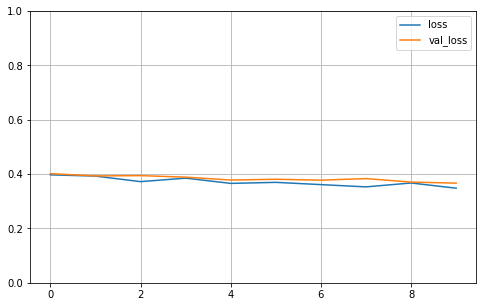

In [ ]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

In [ ]:
model.evaluate(test_set, steps = 5160 // batch_size)

161/161 [==============================] - 0s 2ms/step - loss: 0.3612


0.36124321818351746